In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import cv2
import math
from scipy.signal import convolve2d
from scipy.stats import norm

### test image

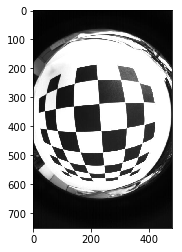

In [2]:
%matplotlib inline
image = plt.imread('../data/04.png')
plt.imshow(image, cmap = 'gray')

## createCorrelationPatch.m
done

In [4]:

class Template:
    def __init__(self, height, width):
        self.a1 = np.zeros((height, width))
        self.b1 = np.zeros((height, width))
        self.a2 = np.zeros((height, width))
        self.b2 = np.zeros((height, width))

    def do_normalize(self):
        self.a1 = self.a1 / np.sum(self.a1)
        self.a2 = self.a2 / np.sum(self.a2)
        self.b1 = self.b1 / np.sum(self.b1)
        self.b2 = self.b2 / np.sum(self.b2)


def createCorrelationPatch(properties):
    angle_1, angle_2, radius = properties

    width  = int(radius*2 + 1)
    height = int(radius*2 + 1)

    # initialize template
    template = Template(height, width)

    # midpoint
    mu = radius
    mv = radius

    # compute normals from angles
    n1 = [-np.sin(angle_1), np.cos(angle_1)]
    n2 = [-np.sin(angle_2), np.cos(angle_2)]

    # for all points in template do

    for v in range(0, height):
        for u in range(0, width):
            # vector
            vec = [u-mu, v-mv]
            dist = np.linalg.norm(vec)

            # check on which side of the normals we are
            s1 = np.matmul(vec, np.transpose(n1))
            s2 = np.matmul(vec, np.transpose(n2))

            if (s1 <= -0.1 and s2 <= -0.1):
                template.a1[v][u] = norm.pdf(dist, 0, radius/2) # x, mu, sigma
            elif (s1 >= 0.1 and s2 >= 0.1):
                template.a2[v][u] = norm.pdf(dist, 0, radius/2)
            elif (s1 <= -0.1 and s2 >= 0.1):
                template.b1[v][u] = norm.pdf(dist, 0, radius/2)
            elif (s1 >= 0.1 and s2 <= -0.1):
                template.b2[v][u] = norm.pdf(dist, 0, radius/2)

    # normalize
    template.do_normalize()
    return template

## nonMaximumSuppression.m
maxima same

In [5]:
def nonMaximumSuppression(img, n, tau, margin):
    height, width = img.shape
    maxima = []

    for j in range(n + margin, height - n - margin + 1, n + 1):
        for i in range(n + margin, width - n - margin + 1, n + 1):
            # initial value
            maxi, maxj = i, j
            maxval = img[j][i]
            # update maxval if found

            for j2 in range(j, j + n + 1):
                for i2 in range(i, i + n + 1):
                    if (img[j2][i2] > maxval):
                        maxi, maxj = i2, j2
                        maxval = img[j2][i2]

            failed = 0

            for j2 in range(maxj - n, min(maxj + n, height - margin) + 1):
                for i2 in range(maxi - n, min(maxi + n, width - margin) + 1):
                    currval = img[j2][i2]
                    if (currval > maxval and (i2 < i or i2 > i + n or j2 < j or j2 > j + n)):
                        failed = 1
                        break
                if (failed):
                    break

            if (maxval >= tau and failed == 0):
                maxima.append([maxi, maxj])

    maxima = np.array(maxima)

    return maxima



## findCorners.m

In [6]:
def findCorners(img, tau, radius):
    # filter image
    print('Start Filtering ...')

    # template properties
    template_props = [[0, np.pi / 2, radius[0]],
                      [np.pi / 4, -np.pi / 4, radius[0]],
                      [0, np.pi / 2, radius[1]],
                      [np.pi / 4, -np.pi / 4, radius[1]],
                      [0, np.pi / 2, radius[2]],
                      [np.pi / 4, -np.pi / 4, radius[2]]]

    img_corners = np.zeros(img.shape)
    for i in range(0, len(template_props)):
        # create correlation template
        template = createCorrelationPatch(template_props[i])

        # filter image according with current template
        img_corners_a1 = convolve2d(img, template.a1, 'same')
        img_corners_a2 = convolve2d(img, template.a2, 'same')
        img_corners_b1 = convolve2d(img, template.b1, 'same')
        img_corners_b2 = convolve2d(img, template.b2, 'same')

        # compute mean
        img_corners_mu = (img_corners_a1 + img_corners_a2 + img_corners_b1 + img_corners_b2) / 4
        # case 1: a=white, b=black
        img_corners_a = np.minimum(np.subtract(img_corners_a1, img_corners_mu),
                                   np.subtract(img_corners_a2, img_corners_mu))
        img_corners_b = np.minimum(np.subtract(img_corners_mu, img_corners_b1),
                                   np.subtract(img_corners_mu, img_corners_b2))
        img_corners_1 = np.minimum(img_corners_a, img_corners_b)

        # case 2: a=black, b=white
        img_corners_a = np.minimum(np.subtract(img_corners_mu, img_corners_a1),
                                   np.subtract(img_corners_mu, img_corners_a2))
        img_corners_b = np.minimum(np.subtract(img_corners_b1, img_corners_mu),
                                   np.subtract(img_corners_b2, img_corners_mu))
        img_corners_2 = np.minimum(img_corners_a, img_corners_b)

        # update corner map
        img_corners = np.maximum(img_corners, img_corners_1)
        img_corners = np.maximum(img_corners, img_corners_2)

    return img_corners


## compute image derivatives

In [7]:

def get_img_derivatives(img):
    # sobel masks
    du = [[-1, 0, 1],
          [-1, 0, 1],
          [-1, 0, 1]]

    dv = [[-1, -1, -1],
          [0, 0, 0],
          [1, 1, 1]]

    img_du = convolve2d(img, du, mode='same')
    img_dv = convolve2d(img, dv, mode='same')
    img_angle = np.arctan2(img_dv, img_du)
    img_weight = np.sqrt(img_du ** 2 + img_dv ** 2)

    # correct angle to lie in between [0,pi]
    h, w = img_angle.shape
    for i in range(0, h):
        for j in range(0, w):
            if (img_angle[i][j] < 0):
                img_angle[i][j] += np.pi
            elif (img_angle[i][j] > np.pi):
                img_angle[i][j] -= np.pi

    return img_du, img_dv, img_angle, img_weight

## findModesMeanShift.m
done

In [8]:

def findModesMeanShift(hist, sigma):
    # efficient mean-shift approximation by histogram smoothing

    # compute smoothed histogram
    hist_smoothed = np.zeros((len(hist)))
    for i in range(0, len(hist)):
        j = np.arange(-np.round(2 * sigma), np.round(2 * sigma) + 1)
        idx = np.mod(i + j, len(hist))
        hist_smoothed[i] = np.sum(hist[idx] * norm.pdf(j, 0, sigma))

    modes = []
    # check if at least one entry is non-zero
    # (otherwise mode finding may run infinitly)
    if np.abs(hist_smoothed - hist_smoothed[0]).any() < 1e-5:
        return

    modes = np.empty((0, 2), float)
    # mode finding
    for i in range(0, len(hist_smoothed)):
        j = i
        while (1):
            j1 = np.mod(j + 1, len(hist))
            j2 = np.mod(j - 1, len(hist))
            h0 = hist_smoothed[j]
            h1 = hist_smoothed[j1]
            h2 = hist_smoothed[j2]
            if (h1 >= h0 and h1 >= h2):
                j = j1
            elif (h2 > h0 and h2 > h1):
                j = j2
            else:
                break

        if len(modes) == 0:
            modes = np.array([[j, hist_smoothed[j]]])
        elif (j not in modes[:, 0]):
            new = np.array([[j, hist_smoothed[j]]])
            modes = np.concatenate((modes, new))

    # sort in descending order
    modes = modes[np.argsort(-modes[:, 1])]

    return modes, hist_smoothed


In [9]:

def edgeOrientations(img_angle, img_weight):
    # init v1 and v2
    v1 = [0, 0]
    v2 = [0, 0]

    # number of bins (histogram parameters)
    bin_num = 32

    # convert images to vectors
    vec_angle = img_angle.T.reshape(-1)
    vec_weight = img_weight.T.reshape(-1)

    # convert angles from normals to directions
    vec_angle = vec_angle + np.pi / 2
    vec_angle[vec_angle > np.pi] -= np.pi

    # create histogram
    angle_hist = np.zeros((bin_num))
    for i in range(0, len(vec_angle)):
        bin = int(max(min(np.floor(vec_angle[i] / (np.pi / bin_num)), bin_num - 1), 0))
        angle_hist[bin] = angle_hist[bin] + vec_weight[i];

    modes, angle_hist_smoothed = findModesMeanShift(angle_hist, 1);

    # if only one or no mode => return invalid corner
    if (len(modes) <= 1):
        return v1, v2

    # compute orientation at modes
    new = modes[:, 0] * np.pi / bin_num
    new = np.reshape(new, (-1, 1))
    modes = np.hstack((modes, new))

    # extract 2 strongest modes and sort by angle
    modes = modes[:2]
    modes = modes[np.argsort(modes[:, 2])]

    # compute angle between modes
    delta_angle = min(modes[1, 2] - modes[0, 2], modes[0, 2] + np.pi - modes[1, 2])

    # if angle too small => return invalid corner
    if (delta_angle <= 0.3):
        return v1, v2

    # set statistics: orientations
    v1 = [np.cos(modes[0, 2]), np.sin(modes[0, 2])]
    v2 = [np.cos(modes[1, 2]), np.sin(modes[1, 2])]

    return v1, v2

## refineCorners.m

In [10]:
class Corners:
    def __init__(self, NMS_corners):
        self.p = NMS_corners.astype(float)
        # init orientations to invalid (corner is invalid iff orientation=0)
        self.v1 = np.zeros(NMS_corners.shape)
        self.v2 = np.zeros(NMS_corners.shape)
        self.score = []
        
def refineCorners(img_du, img_dv, img_angle, img_weight, NMS_corners, r):

    print('Start Refining ...')
    corners = Corners(NMS_corners)
    height, width = img_du.shape

    idx_to_remove = []
    # for all corners do
    for i in range(0, len(corners.p)):
        # extract current corner location
        cu, cv = corners.p[i]
        cu = int(cu)
        cv = int(cv)
        # estimate edge orientations
        img_angle_sub  = img_angle[max(cv-r, 0):min(cv+r+1, height), max(cu-r, 0):min(cu+r+1, width)]
        img_weight_sub = img_weight[max(cv-r, 0):min(cv+r+1, height), max(cu-r, 0):min(cu+r+1, width)]
        v1, v2 = edgeOrientations(img_angle_sub, img_weight_sub)

        corners.v1[i] = v1
        corners.v2[i] = v2

        # continue, if invalid edge orientations
        if (v1 == [0, 0] or v2 == [0, 0]):
            continue
        #################################
        # corner orientation refinement #
        #################################

        A1 = np.zeros((2,2))
        A2 = np.zeros((2,2))

        for v in range(max(cv-r, 0), min(cv+r+1, height)):
            for u in range(max(cu-r, 0), min(cu+r+1, width)):
                # pixel orientation vector
                o = [img_du[v, u], img_dv[v, u]]
                if (np.linalg.norm(o) < 0.1):
                    continue
                o = o / np.linalg.norm(o)
                # robust refinement of orientation 1
                if(np.abs(np.matmul(o, v1)) < 0.25): # inlier?
                    A1[0] = A1[0] + img_du[v, u] * np.array([img_du[v, u], img_dv[v, u]])
                    A1[1] = A1[1] + img_dv[v, u] * np.array([img_du[v, u], img_dv[v, u]])

                # robust refinement of orientation 2
                if(np.abs(np.matmul(o, v2)) < 0.25): # inlier?
                    A2[0] = A2[0] + img_du[v, u] * np.array([img_du[v, u], img_dv[v, u]])
                    A2[1] = A2[1] + img_dv[v, u] * np.array([img_du[v, u], img_dv[v, u]])


        # set new corner orientation

        foo1, v1 = LA.eig(A1)      # eigenvalue, eigenvector
        min_eigenval_idx = np.argmin(foo1)
        v1 = v1[:, min_eigenval_idx]
        corners.v1[i] = v1

        foo2, v2 = LA.eig(A2)
        min_eigenval_idx = np.argmin(foo2)
        v2 = v2[:,min_eigenval_idx]
        corners.v2[i] = v2

        ##############################
        # corner location refinement #
        ##############################
        G = np.zeros((2,2))
        b = np.zeros((2,1))

        for v in range(max(cv - r, 0), min(cv + r+1, height)):
            for u in range(max(cu-r, 0), min(cu+r+1, width)):
                # pixel orientation vector
                o = [img_du[v, u], img_dv[v, u]]
                if (np.linalg.norm(o) < 0.1):
                    continue
                o = o / np.linalg.norm(o)

                # robust subpixel corner estimation
                if (cu != u or v != cv): # do not consider center pixel

                    #compute rel. position of pixel and distance to vectors
                    w = np.subtract([u, v], [cu, cv])
                    d1 = np.linalg.norm(w - np.matmul(w, v1) * v1)
                    d2 = np.linalg.norm(w - np.matmul(w, v2) * v2)

                    # if pixel corresponds with either of the vectors / directions
                    if ((d1 < 3 and np.abs(np.matmul(o, v1)) < 0.25) or (d2 < 3 and np.abs(np.matmul(o, v2)) < 0.25)):
                        du = img_du[v, u]
                        dv = img_dv[v, u]
                        H = np.matmul(np.transpose([[du, dv]]), np.array([[du, dv]]))
                        G = G + H
                        b = np.add(b, np.matmul(H, np.array(np.transpose([[u, v]]))))

        # set new corner location if G has full rank
        if (LA.matrix_rank(G) == 2):
            corner_pos_old = corners.p[i]
            corner_pos_new = np.transpose(np.matmul(LA.inv(G), b))

            # set corner to invalid, if position update is very large
            if (np.linalg.norm(corner_pos_new - corner_pos_old) >= 4):
                idx_to_remove.append(i)
                corners.v1[i] = [0, 0]
                corners.v2[i] = [0, 0]

            corners.p[i] = corner_pos_new ######

        # otherwise: set corner to invalid
        else:
            idx_to_remove.append(i)
            corners.v1[i] = [0, 0]
            corners.v2[i] = [0, 0]

    # remove corners without edges
    corners.p = np.delete(corners.p, idx_to_remove, 0)
    corners.v1 = np.delete(corners.v1, idx_to_remove, 0)
    corners.v2 = np.delete(corners.v2, idx_to_remove, 0)

    return corners

In [13]:
def plotCorners(img, corners):
    plt.figure(figsize = (16, 8))
    implot = plt.imshow(img)
    plt.scatter(corners[:, 0], corners[:, 1], color = 'red')
    plt.show()

    return 0

## demo.m

In [14]:
img = plt.imread('../data/01.png')

# use 3 scales to obtain a modest level of scale invariance and robustness w.r.t blur
radius = [4, 8, 12]

# normalize values between [0, 1]
img = cv2.normalize(img.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

# convert to grayscale image
if (len(img.shape) == 3):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


# compute image derivatives
img_du, img_dv, img_angle, img_weight = get_img_derivatives(img)

# scale input image
img = (img - np.min(img)) / (np.max(img) - np.min(img))

# find initial corners
initial_corners = findCorners(img, 0.01, radius)

# extract corner candidates via non maximum suppressions
NMS_corners = nonMaximumSuppression(initial_corners, 3, 0.025, 5)


Start Filtering ...


Start Refining ...


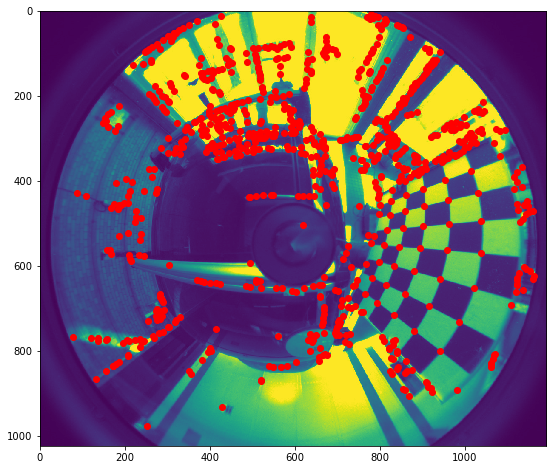

0

In [15]:
# subpixel refinement
refined_corners = refineCorners(img_du, img_dv, img_angle, img_weight, NMS_corners, 10)
plotCorners(img, refined_corners.p)

Start Scoring ...


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


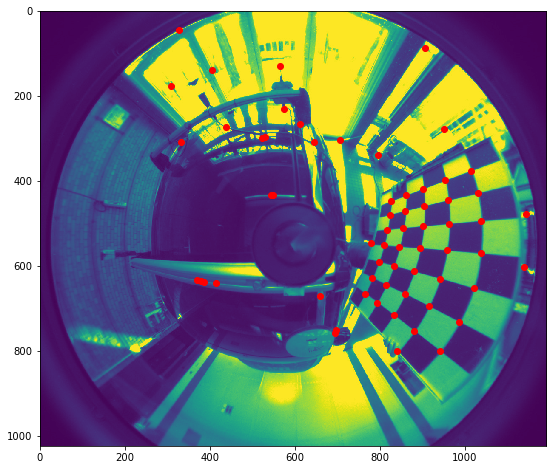

In [16]:
# score corners
final_corners = scoreCorners(img, img_angle, img_weight, refined_corners, radius, 0.01)
plotCorners(img, final_corners.p)

# make v1(:,1)+v1(:,2) positive
idx = final_corners.v1[:, 0] + final_corners.v1[:, 1] < 0
final_corners.v1[idx, :] = -final_corners.v1[idx, :]


In [19]:
class Corners:
    def __init__(self, NMS_corners):
        self.p = NMS_corners.astype(float)
        # init orientations to invalid (corner is invalid iff orientation=0)
        self.v1 = np.zeros(NMS_corners.shape)
        self.v2 = np.zeros(NMS_corners.shape)
        self.score = []

In [200]:
corners = Corners(NMS_corners)
height, width = img_du.shape

idx_to_remove = []
# for all corners do
i=0
# extract current corner location
cu, cv = corners.p[i].astype(int)

# estimate edge orientations
img_angle_sub  = img_angle[max(cv-r, 0):min(cv+r+1, height), max(cu-r, 0):min(cu+r+1, width)]
img_weight_sub = img_weight[max(cv-r, 0):min(cv+r+1, height), max(cu-r, 0):min(cu+r+1, width)]
v1, v2 = edgeOrientations(img_angle_sub, img_weight_sub)

corners.v1[i] = v1
corners.v2[i] = v2



In [201]:
ran = 88
r = 3

In [203]:
#################################
# corner orientation refinement #
#################################

A1 = np.zeros((2,2))
A2 = np.zeros((2,2))
cnt = 0
for v in range(max(cv-r, 0), min(cv+r+1, height)):
    for u in range(max(cu-r, 0), min(cu+r+1, width)):
        cnt = cnt +1 
        # pixel orientation vector
        o = [img_du[v, u], img_dv[v, u]]
        if (np.linalg.norm(o) < 0.1):
            continue
        o = o / np.linalg.norm(o)
        # robust refinement of orientation 1
        if(np.abs(np.matmul(o, v1)) < 0.25): # inlier?
            A1[0] = A1[0] + img_du[v, u] * np.array([img_du[v, u], img_dv[v, u]])
            A1[1] = A1[1] + img_dv[v, u] * np.array([img_du[v, u], img_dv[v, u]])

            
print(cnt)            
print('*'*30)
print(A1)

49
******************************
[[ 0.89420981  0.42871198]
 [ 0.42871198  0.21437906]]


## modifying

In [218]:
A1 = np.zeros((2, 2))
A2 = np.zeros((2, 2))

img_du_sub = img_du[max(cv - r, 0): min(cv + r + 1, height), max(cu - r, 0): min(cu + r + 1, width)]
img_dv_sub = img_dv[max(cv - r, 0): min(cv + r + 1, height), max(cu - r, 0): min(cu + r + 1, width)]
img_du_vec = img_du_sub.reshape(-1, 1)
img_dv_vec = img_dv_sub.reshape(-1, 1)

# pixel orientation vector
o_vec = np.hstack((img_du_vec, img_dv_vec))
o_vec = o_vec[np.where(np.linalg.norm(o_vec, axis=1) >= 0.1)]
o_norm_vec = np.divide(o_vec, np.linalg.norm(o_vec, axis=1).reshape(-1, 1))

# robust refinement of orientation 1
idx = np.abs(np.matmul(o_norm_vec, v1)) < 0.25
A1[0] = np.sum((o_vec[idx][:, 0] * o_vec[idx].T).T, axis=0)
A1[1] = np.sum((o_vec[idx][:, 1] * o_vec[idx].T).T, axis=0)

# robust refinement of orientation 2
idx = np.abs(np.matmul(o_norm_vec, v2)) < 0.25
A2[0] = np.sum((o_vec[idx][:,0] * o_vec[idx].T).T, axis = 0)
A2[1] = np.sum((o_vec[idx][:,1] * o_vec[idx].T).T, axis = 0)

print(A1)

[[ 0.02031526  0.07821606]
 [ 0.07821606  0.34559012]]


In [219]:
# set new corner orientation
foo1, v1 = LA.eig(A1)  # eigenvalue, eigenvector
min_eigenval_idx = np.argmin(foo1)
v1 = v1[:, min_eigenval_idx]
corners.v1[i] = v1

foo2, v2 = LA.eig(A2)
min_eigenval_idx = np.argmin(foo2)
v2 = v2[:, min_eigenval_idx]
corners.v2[i] = v2


In [414]:
##############################
# corner location refinement #
##############################
G = np.zeros((2, 2))
b = np.zeros((2, 1))
for v in range(max(cv - r, 0), min(cv + r + 1, height)):
    for u in range(max(cu - r, 0), min(cu + r + 1, width)):
        # pixel orientation vector
        o = [img_du[v, u], img_dv[v, u]]

        if np.linalg.norm(o) < 0.1:
            continue
        o = o / np.linalg.norm(o)

        # robust subpixel corner estimation
        if u != cu or v != cv:  # do not consider center pixel
            # compute rel. position of pixel and distance to vectors
            w = np.subtract([u, v], [cu, cv])
            d1 = np.linalg.norm(w - np.matmul(w, v1) * v1)
            d2 = np.linalg.norm(w - np.matmul(w, v2) * v2)
            # if pixel corresponds with either of the vectors / directions
            if (d1 < 3 and np.abs(np.matmul(o, v1)) < 0.25) or (d2 < 3 and np.abs(np.matmul(o, v2)) < 0.25):
                du = img_du[v, u]
                dv = img_dv[v, u]
                H = np.matmul(np.transpose([[du, dv]]), np.array([[du, dv]]))
                #print('h =', H)
                G = G + H
                #print([[u, v]])
                b = np.add(b, np.matmul(H, np.array(np.transpose([[u, v]]))))
                print('b = ',b)

print(G)
print(b)

b =  [[ 1.0120414 ]
 [ 3.79515526]]
b =  [[ 1.58325241]
 [ 5.38185249]]
b =  [[  4.16479766]
 [ 13.12648825]]
b =  [[  8.33697709]
 [ 27.38143464]]
b =  [[ 17.93808321]
 [ 66.31925392]]
[[ 0.03780084  0.13951555]
 [ 0.13951555  0.52193765]]
[[ 17.93808321]
 [ 66.31925392]]


In [415]:
##############################
# corner location refinement #
##############################
G = np.zeros((2, 2))
b = np.zeros((2, 1))

pos_uv = np.mgrid[max(cu - r, 0): min(cu + r + 1, width), max(cv - r, 0): min(cv + r + 1, height)].T.reshape(-1, 2)
pos_uv = pos_uv[idx]

w = np.subtract(pos_uv, [cu, cv])
# do not consider center pixel
w = w[np.where(w.any(axis = 1))]

d1 = np.linalg.norm(w - (np.matmul(w, v1).reshape(-1,1) * v1), axis = 1)
d2 = np.linalg.norm(w - (np.matmul(w, v2).reshape(-1,1) * v2), axis = 1)

idx1 = np.where(((d1<3) & (np.abs(np.matmul(o_norm_vec, v1)) < 0.25)) | 
                ((d2<3) & (np.abs(np.matmul(o_norm_vec, v2)) < 0.25)))

G = np.matmul(o_vec[idx1].T, o_vec[idx1])
print(G)

[[ 0.03780084  0.13951555]
 [ 0.13951555  0.52193765]]


In [389]:
(o_vec[idx1][:,0] * o_vec[idx1].T).T

array([[ 0.00221453,  0.0083045 ],
       [ 0.00124567,  0.00346021],
       [ 0.00555171,  0.01665513],
       [ 0.00885813,  0.03026528],
       [ 0.01993079,  0.08083044]])

In [416]:

H1 = (o_vec[idx1][:,0] * o_vec[idx1].T).T
H2 = (o_vec[idx1][:,1] * o_vec[idx1].T).T
H = np.concatenate((H1, H2), axis = 1).reshape(-1,2)



In [420]:
np.multiply(H[:,0], np.repeat(pos_uv[idx1][:,0], repeats =2, axis=0))

array([  0.94560542,   3.54602034,   0.53314873,   1.48096868,
         2.38168368,   7.14505105,   3.80899609,  13.01406996,
         8.5503104 ,  34.67625884])

In [406]:
np.repeat(pos_uv[idx1][:,0], repeats =2, axis=0)

array([427, 427, 428, 428, 429, 429, 430, 430, 429, 429])